<a href="https://colab.research.google.com/github/linneverh/MachineLearning/blob/Assignment/assignments/Part%205/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DSML investigation

You are part of the Suisse Impossible Mission Force, or SIMF for short. You need to uncover a rogue agent that is trying to steal sensitive information.

Your mission, should you choose to accept it, is to find that agent before stealing any classified information. Good luck!

# Assignment part five

More information came in that suggests that the rogue agent is tampering with the sentiment annotation system of the SIMF which analyses news documents and marks their sentiment for intelligence analysis tasks.

This annotation is crucial to identify documents expressing negativity towards Switzerland and its allies.

Each document contains a column which shows which user accessed it. We know that the rogue agent accessed only the documents whose negative sentiment was high, and then changed them to positive or neutral. We will use a huggingface model to identify which records have been tampered with.


[You can find more models on this link](https://huggingface.co/models?sort=trending)


In [1]:
# Install the required libraries (you need to run this cell ONLY if you are running the notebook locally)
# No need to run this cell in colab!
%%capture
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs
!pip install transformers[torch]
!pip install accelerate -U
!pip install openpyxl

!pip install -q transformers
%pip install ipywidgets
%pip install --upgrade transformers huggingface_hub torch



In [2]:
# Import required packages
from transformers import pipeline, DataCollatorWithPadding
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

torch.cuda.is_available()

# Import standard libraries
import pandas as pd
import numpy as np
import math
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Import for text analytics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Import metrics libraries
from sklearn.metrics import confusion_matrix, accuracy_score



# 1. Getting to know our data

In [3]:

df = pd.read_excel('https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/refs/heads/main/assignments/Part%205/data/Reduced_Set_2100.xlsx')

In [4]:
df.head(2)

,company,title,news,evaluation,year,month,day
0,APPLE,Tourists snap up British iPads to smuggle into...,IT'S the digital version of the slow boat to C...,negative,2011,4,17
1,CHEVRON,AFTER SEATTLE; Anarchists get organized.,"For Juliette Beck, it began with the story of ...",negative,2000,4,17


### 2. Re-evaluating with SIMF's Model

We will re-evaluate the sentiment on the `title` column using a sentiment analysis pipeline based on the `finiteautomata/bertweet-base-sentiment-analysis` model. This is a sentiment analysis model trained on ~40k tweets. It classifies a text as `POS` (positive), `NEU` (neutral), or `NEG` (negative) sentiment.

Initialize a sentiment analysis classifier with the pre-trained model mentioned above, making sure to set the correct value for the `task` parameter.

**Note**: Set the `top_k` argument to `None` to retrieve the probabilities for all possible sentiment labels in the output.

_This process may take some time._

In [19]:
# Your code here
# Load sentiment analysis model from Hugging Face
sentiment_classifier = pipeline(
    task="sentiment-analysis",
    model="finiteautomata/bertweet-base-sentiment-analysis",
    top_k=None  # This returns probabilities for all labels (POS, NEU, NEG)
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu


Apply the sentiment classifier to the `title` column and assign the corresponding sentiment labels to a new column in your dataframe.

Make sure to convert the sentiment labels from the model by replacing them with more descriptive terms like this:
- **NEU**: neutral
- **NEG**: negative
- **POS**: positive

*Hint: Be mindful of the format of the classifier’s output.*

_Beware that applying the model on all of the rows may take some time_

In [20]:
# Your code here
# Apply the sentiment classifier to the title column
# This may take a few minutes depending on the number of rows
results = sentiment_classifier(df['title'].tolist(), truncation=True)

# Each result is a list of dictionaries, since we used top_k=None
# We'll extract the label with the highest score for each title
predicted_labels = [max(r, key=lambda x: x['score'])['label'] for r in results]

# Map short labels to more descriptive terms
label_mapping = {
    "NEU": "neutral",
    "NEG": "negative",
    "POS": "positive"
}

# Apply the mapping
df['pr_sentiment'] = [label_mapping[label] for label in predicted_labels]

# Quick check
df[['title', 'pr_sentiment']].head()

,title,pr_sentiment
0,Tourists snap up British iPads to smuggle into...,neutral
1,AFTER SEATTLE; Anarchists get organized.,neutral
2,$10bn oil payout voided,negative
3,Craft capitalism: Just do it yourself; Web mar...,positive
4,Chevron gas project gets state green light,neutral


Now, display the number of unique sentiment evaluations for both the Hugging Face and SIMF models to compare the distribution of labels.

Next, calculate and display the accuracy of the Hugging Face sentiment analysis compared to the SIMF evaluation. Finally, visualize the comparison using a heatmap of the confusion matrix to better understand where the two models align or differ.

SIMF model sentiment distribution:
evaluation
negative    700
neutral     700
positive    700
Name: count, dtype: int64

Hugging Face (BERTweet) sentiment distribution:
pr_sentiment
neutral     1380
negative     384
positive     336
Name: count, dtype: int64

Accuracy of Hugging Face sentiment model vs SIMF evaluation: 43.48%


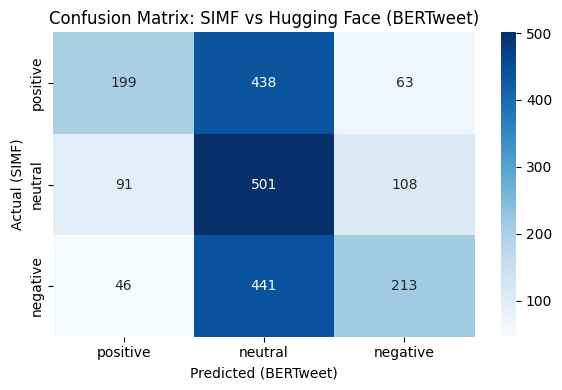

In [21]:
# Your code here
# Step 1: Count sentiment label distributions
print("SIMF model sentiment distribution:")
print(df['evaluation'].value_counts())

print("\nHugging Face (BERTweet) sentiment distribution:")
print(df['pr_sentiment'].value_counts())

# Step 2: Calculate accuracy
accuracy = accuracy_score(df['evaluation'], df['pr_sentiment'])
print(f"\nAccuracy of Hugging Face sentiment model vs SIMF evaluation: {accuracy:.2%}")

# Step 3: Confusion matrix
conf_mat = confusion_matrix(df['evaluation'], df['pr_sentiment'], labels=['positive', 'neutral', 'negative'])

# Step 4: Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.title('Confusion Matrix: SIMF vs Hugging Face (BERTweet)')
plt.xlabel('Predicted (BERTweet)')
plt.ylabel('Actual (SIMF)')
plt.tight_layout()
plt.show()


**Q1. Does the SIMF sentiment classifier predicts more samples to be "neutral"  compared to the Hugging Face sentiment classifier?**
ANSWER: NO, IT PREDICTS LESS NEUTRAL 700 vs 1380

## 2.1 Entries match both the SIMF model **and** the hugginface model

The SIMF model values are found in the `evaluation` column, while the hugginface model values should be found in the `new_column`, which you added to the table in the previous step.

Display:
*   The rows/records with same sentiment for both models.
*   The number of matching values.
*   The share of matching values of the total number of values.



In [22]:
# Your code here
# Step 1: Rows where SIMF and Hugging Face (BERTweet) models agree
matching = df[df['evaluation'] == df['pr_sentiment']]
display(matching.head())

# Step 2: Number of matching values
num_matches = len(matching)
print(f"Number of matching sentiment labels: {num_matches}")

# Step 3: Share of matching values
total = len(df)
match_share = num_matches / total
print(f"Share of matches: {match_share:.2%}")

,company,title,news,evaluation,year,month,day,pr_sentiment
2,Exxon Mobil,$10bn oil payout voided,SAN FRANCISCO: An appeal court yesterday voide...,negative,2001,11,9,negative
12,MICROSOFT,"Greenpeace slams Microsoft, Nintendo's 'toxic'...",AMSTERDAM - Microsoft and Nintendo are taking ...,negative,2007,11,29,negative
13,PEPSICO,PESTICIDE PANIC,NEW DELHI: India's top court has asked local s...,negative,2006,8,6,negative
14,Exxon Mobil,"High-cost oil projects may be wasted, report says",More than $1tn (£600bn) is being gambled on hi...,negative,2014,5,8,negative
23,Exxon Mobil,MORE TOXIC SLUDGE FEARED IN WATERWAY,WORKERS BUILDING a park on Newtown Creek hit u...,negative,2005,2,24,negative


Number of matching sentiment labels: 913
Share of matches: 43.48%


**Q2. How many entries are identical between the SIMF model evaluation and the Hugging Face model evaluation?**

*Note: Provide your answer as an integer (e.g., 80).*
<br> ANSWER = 913

## 2.2 Entries that do not match both models
Identify all non matching entries.

Create a subset with all the entries that were evaluated differently by the two models.

In [23]:
# Your code here
# Step 1: Filter non-matching rows
mismatching = df[df['evaluation'] != df['pr_sentiment']]

# Step 2: Preview mismatches
display(mismatching.head())

# Step 3: Check number of mismatches
print(f"Number of mismatching sentiment evaluations: {len(mismatching)}")

,company,title,news,evaluation,year,month,day,pr_sentiment
0,APPLE,Tourists snap up British iPads to smuggle into...,IT'S the digital version of the slow boat to C...,negative,2011,4,17,neutral
1,CHEVRON,AFTER SEATTLE; Anarchists get organized.,"For Juliette Beck, it began with the story of ...",negative,2000,4,17,neutral
3,WAL MART STORES,Craft capitalism: Just do it yourself; Web mar...,The declaration from the Handmade Consortium m...,negative,2007,12,15,positive
4,Exxon Mobil,Chevron gas project gets state green light,SYDNEY: Chevron has received final environment...,negative,2007,9,8,neutral
5,CHEVRON,RIVALS WILL ACCUSE BP,[…] BP was expected to be hung out to dry by r...,negative,2010,6,15,neutral


Number of mismatching sentiment evaluations: 1187


## 2.3 Predicted negative, but evaluated as neutral or positive by the SIMF model

Remember, we are looking at document that were tempered (altered). We suspect that the rogue agent accessed only the documents whose negative sentiment was high, and was then changed to positive or neutral.

Create a subset with only those values, which appear as 'positive' or 'neutral' in the original `evaluation` column, but are marked as having a 'negative' sentiment by the new hugginface model.

**This subset is what we'll call the end of the assignment : "Altered Documents".**

In [25]:
# Your code here
# Step 1: Filter for altered documents
altered_documents = df[
    (df['evaluation'].isin(['positive', 'neutral'])) &
    (df['pr_sentiment'] == 'negative')
]

# Step 2: Preview the altered documents
display(altered_documents.head())

# Step 3: Report how many documents were potentially altered
print(f"Number of potentially altered documents: {len(altered_documents)}")

,company,title,news,evaluation,year,month,day,pr_sentiment
702,BANK OF AMERICA,Letters: Anger simmers over energy bills; Thes...,"[…] Ending our addiction to fossil fuels, slas...",neutral,2013,10,17,negative
715,VERIZON COMMUNICATIONS,So How Contaminated Is the Old Nuclear Plant?,"[…] From 1952 to 1966, when operations ceased ...",neutral,2002,1,13,negative
722,CITIGROUP,Front: Carbon bubble 'creates global economic ...,The world could be heading for a major economi...,neutral,2013,4,19,negative
733,CITIGROUP,Report says officials are shortsighted big spe...,Government officials are guilty of wasting mon...,neutral,2003,11,27,negative
738,CITIGROUP,Miners to bear cost of climate toll,"RESOURCE companies, along with transporter Tol...",neutral,2006,12,11,negative


Number of potentially altered documents: 171


**Q3. How many entries were changed from a negative evaluation (in the Hugging Face model) to a neutral or positive evaluation (by the SIMF model)?**

*Note: Provide your answer as an integer (e.g., 45).*
<BR> ANSWER = 171


# 3. Use the ChangeLog dataframe to identify the usersID's who edited the entries.

Consider the subset you created in the previous step : *the altered documents*.

By combining it with ChangeLog, display only those userIDs, that belong to the people who tried to mask the 'negative' sentiments by assigning these sentences a 'positive' or 'neutral' value.

In other words, match the previous subset with corresponding UserIDs.

In [11]:
ChangeLog = pd.read_csv('https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/refs/heads/main/assignments/Part%205/data/ChangeLogFix.csv')

In [12]:
display(ChangeLog.head(10))

,UserID,title
0,[327047],Tourists snap up British iPads to smuggle into...
1,[401818],Tourists snap up British iPads to smuggle into...
2,[564061],Tourists snap up British iPads to smuggle into...
3,[446376],Tourists snap up British iPads to smuggle into...
4,[242912],AFTER SEATTLE; Anarchists get organized.
5,[645264],AFTER SEATTLE; Anarchists get organized.
6,[654139],$10bn oil payout voided
7,[162287],$10bn oil payout voided
8,[682811],$10bn oil payout voided
9,[910568],Craft capitalism: Just do it yourself; Web mar...


In [30]:
# Your code here
# Step 1: Match titles from the altered documents to those in the ChangeLog
suspicious_edits = ChangeLog[ChangeLog['title'].isin(altered_documents['title'])]

# Step 2: Show the matched userIDs and titles
display(suspicious_edits[['UserID', 'title']].drop_duplicates())

# Step 3: Optional – count how many altered edits each user made
print("Number of altered entries edited by each user:")
print(suspicious_edits['UserID'].value_counts())


,UserID,title
973,[140991],TRENDS RAIN-FOREST CHIC Maybe Ben & Jerry'...
974,[628864],TRENDS RAIN-FOREST CHIC Maybe Ben & Jerry'...
1365,[241404],Letters: Anger simmers over energy bills; Thes...
1366,[535048],Letters: Anger simmers over energy bills; Thes...
1367,[780084],Letters: Anger simmers over energy bills; Thes...
...,...,...
3987,[398434],TRENDS RAIN-FOREST CHIC Maybe Ben & Jerry'...
3989,[642133],Vancouver snub 'disappoints' Wal-Mart
4071,[859112],PM gets bad greenhouse mail
4072,[486395],PM gets bad greenhouse mail


Number of altered entries edited by each user:
UserID
[791891]    3
[131191]    3
[536355]    3
[515957]    3
[638911]    3
           ..
[907542]    1
[531937]    1
[255830]    1
[767527]    1
[553754]    1
Name: count, Length: 266, dtype: int64


In [45]:
# Step 1: Extract unique UserIDs who edited altered documents
suspect_user_ids = suspicious_edits['UserID'].unique()

# Step 2: Provided options to check (from the screenshot)
options_to_check = [241404, 535048, 515957, 850103, 910222]

# Step 3: Check which of the options are actually in the list of suspects
remaining_suspects = [uid for uid in options_to_check if uid in suspect_user_ids]

print(" These user IDs are confirmed suspects:")
print(remaining_suspects)

 These user IDs are confirmed suspects:
[]


**Q4. Which of the following users remain suspects when considering only the documents evaluated as negative by the Hugging Face model but not by the SIMF model?**

*Note: Select among the following answers*

### 4. Identifying Key Information in the Altered Documents

In this section, we will use the **TF-IDF** (Term Frequency-Inverse Document Frequency) features to identify significant terms in the *altered documents*.

Start by creating a list of all the original texts from the `news` column in the dataframe `df`.


In [34]:
# Your code here
# Step 1: Extract the list of full news texts for the altered documents
original_texts = df['news'].tolist()

["IT'S the digital version of the slow boat to China. The iPad 2, made in China but yet to go on sale there, is being bought in London and smuggled back into the country where it is manufactured.  It means the Apple tablet is creating extra carbon emissions as it travels halfway across the world and back again. Customers are queuing to buy the iPad 2 at Apple shops in London and send them 6,000 miles back to China. The tablets are bought for their retail price of £399 for a 16GB model and then taken to China, where they sell for £430. The profit is not in this small mark-up but in the 20% Vat - in this case almost £80 - Chinese tourists can reclaim when they take the iPads out of the country. No tax is paid to the Chinese authorities by the smugglers. It means a student who takes home six iPads can fund his trip to London. […]",
 'For Juliette Beck, it began with the story of the Ittu Oromo, Ethiopian nomads whose lives were destroyed, in vast numbers, by a dam-a hydroelectric project 


Initialize the `TfidfVectorizer` with unigrams (`ngram_range=(1, 1)`) and set the `stop_words` parameter to `'english'` to exclude common English words from the analysis.


Apply the vectorizer to the corpus of text and convert the resulting document-term matrix into a DataFrame for easy visualization and analysis.


In [41]:
# Your code here
# Step 1: Initialize the TF-IDF vectorizer
# - ngram_range=(1, 1) = unigrams (single words)
# - stop_words='english' = remove common English words
vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')

# Step 2: Fit and transform the text corpus
tfidf_matrix = vectorizer.fit_transform(original_texts)

# Step 3: Convert to DataFrame for easy inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Optional: Preview
tfidf_df.head()

,00,000,000b,000billion,000kg,000km,000kwh,000mt,000mwh,000sqkm,...,zoning,zoo,zoologist,zorigt,zoé,zse,zucker,zuckerberg,zune,zurich
0,0.0,0.054857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now want to focus solely on the **"altered documents"**.

To do this, use the previously created list that contains the documents where the Hugging Face model gave a **negative** evaluation, but the SIMF model evaluated them as **neutral** or **positive**.

From this list of documents, extract the corresponding text from the `news` column to obtain a list of articles.

In [42]:
# Your code here
# Step 1: Create the list of news articles for altered documents
altered_texts = altered_documents['news'].tolist()

# Optional: Check how many and preview one
print(f"Number of altered documents: {len(altered_texts)}")
print("\nExample altered document:\n")
print(altered_texts[0][:500])  # Show first 500 characters

Number of altered documents: 171

Example altered document:

[…] Ending our addiction to fossil fuels, slashing energy waste and developing the United Kingdom's huge renewable energy resources would not only provide us with an affordable energy system, it would also help combat the growing threat of climate change. Last month major financial institutions, including the BANK OF AMERICA and the insurance giant Aviva, accused the Government of scaring off investment in Britain's renewable energy sector because of its refusal to include a power-sector decarbo


Now, we will identify the document that stands out the most among the altered documents based on the TF-IDF values.

1. **Filter the TF-IDF DataFrame**: Keep only the entries from the `tfidf_df` that correspond to the tampered documents.
   
2. **Sum TF-IDF Values**: For each tampered document, calculate the sum of the TF-IDF values across all tokens. This gives an overall importance score for each document.

3. **Find the Most Significant Document**: Identify the document with the highest summed TF-IDF value, which stands out the most. Retrieve its index from the original DataFrame `df` and display the details of this document.

In [43]:
# Your code here
# Step 1: Vectorize the altered texts using the same TF-IDF setup
altered_vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
altered_tfidf_matrix = altered_vectorizer.fit_transform(altered_texts)

# Step 2: Sum TF-IDF values per document (row-wise)
tfidf_sums = altered_tfidf_matrix.sum(axis=1)

# Step 3: Identify the index of the document with the highest TF-IDF total
most_significant_idx = tfidf_sums.argmax()

# Step 4: Retrieve and display that document's info from the original DataFrame
most_significant_doc = altered_documents.iloc[most_significant_idx]
print("Most significant altered document:")
display(most_significant_doc)


Most significant altered document:


,1761
company,GENERAL ELECTRIC
title,Force of Nature; Environmentalism is no longer...
news,It seems like a hippie entrepreneur's dream co...
evaluation,positive
year,2006
month,8
day,14
pr_sentiment,negative


**Q5. What is the name's company of the most important altered document?**

*Note: The most important altered document means the document with the highest summed TF-IDF value.*
<BR> GENERAL ELECTRIC

Now, across the altered documents, let's identify the words that stand out the most, meaning those with the highest summed TF-IDF values.

To achieve this, sum the values of each column in the altered TF-IDF dataframe, since each column represents a token. Then, sort these summed values in descending order to easily identify the top 4 words with the highest TF-IDF scores.

Once you have these top 4 words, count in how many *altered documents* each top word appeared.

In [44]:
# Your code here
# Step 1: Convert altered TF-IDF matrix into a DataFrame for analysis
altered_tfidf_df = pd.DataFrame(
    altered_tfidf_matrix.toarray(),
    columns=altered_vectorizer.get_feature_names_out()
)

# Step 2: Sum TF-IDF values for each token (i.e., each column)
token_importance = altered_tfidf_df.sum(axis=0)

# Step 3: Sort tokens by importance (highest summed TF-IDF value)
top_tokens = token_importance.sort_values(ascending=False).head(4)
print("Top 4 tokens by total TF-IDF value across altered documents:")
print(top_tokens)

# Step 4: Count in how many documents each top token appears
print("\n Frequency of top tokens across altered documents:")
for token in top_tokens.index:
    count = (altered_tfidf_df[token] > 0).sum()
    print(f"'{token}' appears in {count} altered documents")


Top 4 tokens by total TF-IDF value across altered documents:
said       5.882174
carbon     5.610031
energy     5.326920
climate    4.787873
dtype: float64

 Frequency of top tokens across altered documents:
'said' appears in 97 altered documents
'carbon' appears in 55 altered documents
'energy' appears in 70 altered documents
'climate' appears in 49 altered documents


**Q6. What is the token with the highest summed TF-IDF value?**

*Note: Select among the following answers*
<BR> highest TF-IDF value is 'said'

**Q7. In how many altered documents do the third most frequent word appeared ?**

*Note: Provide your answer as an integer (e.g., 45).*
<BR> 70

## Your investigation is progressing effectively, and the list of suspects is narrowing down.

**Don't forget to answer the quiz and submit your code on Moodle before the end of the deadline.**